# Well-being indicators


The next step is to use the three classifiers trained in the mental health status classification task and use them to create an indicator. This will be done by feeding the models a series of tweets, classifying the said tweets, and then using the results to construct a time series based on the frequency of each class. The tweets used for this step are from a dataset that contains around 15 million tweets for the first five months of 2020. The tweets were extracted using the Twitter API, with their language being Italian (source: Istat). For each day, 3000 tweets were sampled from the dataset due to computational reasons. These tweets had the same pre-processing steps as mentioned in the model specific notebooks and then were given to the models as input. The frequency for each day was normalized by dividing the frequency of each class by 3000 and the 7 day moving average was also computed. This notebook analyzes the indicator associated with each class.

**Note:** The dataset for the tweets is not included in this repository as it belongs to Istat.


## Imports

In [1]:
import pandas as pd
import plotly.express as px
import numpy as np
import pandas as pd
from scipy.stats import gaussian_kde
import plotly.graph_objects as go
import pandas as pd

In [8]:
df = pd.read_csv('/content/drive/MyDrive/Italian thesis/Training dataset/italian_with_predictions_and_logits.csv')

In [9]:
df.head()

,testo,tweet_date,llama_logits,llama_prediction,bert_logits,bert_prediction,lstm_prediction,lstm_logits
0,l istruzione e la ricchezza posson essere sorg...,2020-01-31,"[-2.353515625, 4.1796875, -2.923828125, -2.949...",1,"[-0.4601691961288452, 3.44775390625, -1.441370...",1,1,[0.00560762 0.98213357 0.0028632 0.00939566]
1,ce l abbiamo fatta tutti in pratica parco nord...,2020-01-31,"[0.2763671875, 3.181640625, -5.38671875, 0.232...",1,"[-1.0215137004852295, 4.273667335510254, -1.83...",1,1,[0.0241121 0.935124 0.01717451 0.02358937]
2,qualcuno poi mi spieghi tutto il credito che s...,2020-01-31,"[-0.0018262863159179688, 2.484375, -7.28125, -...",1,"[1.2525972127914429, 0.6674477458000183, -1.16...",0,1,[0.01570666 0.9717164 0.00518726 0.00738971]
3,aforismi f duva mov stelle e chi lo rappresent...,2020-01-31,"[0.78662109375, 3.923828125, -7.43359375, 0.48...",1,"[-0.9413514137268066, 4.013585567474365, -0.89...",1,1,[0.00552873 0.981455 0.01097759 0.0020386 ]
4,di solito quando un prodotto ha bisogno di tan...,2020-01-31,"[-0.41552734375, 5.20703125, -7.1796875, -1.48...",1,"[-0.9259320497512817, 3.9972760677337646, -1.7...",1,1,[0.01498423 0.96955764 0.00705393 0.00840417]


## Indicator graphs

### Using matplotlib

<ipython-input-10-220b918cbaca>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



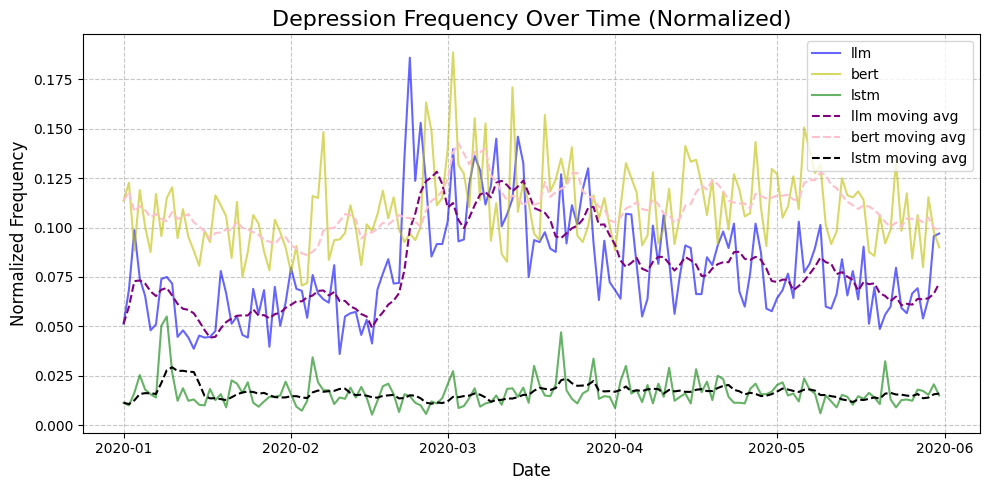

<ipython-input-10-220b918cbaca>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



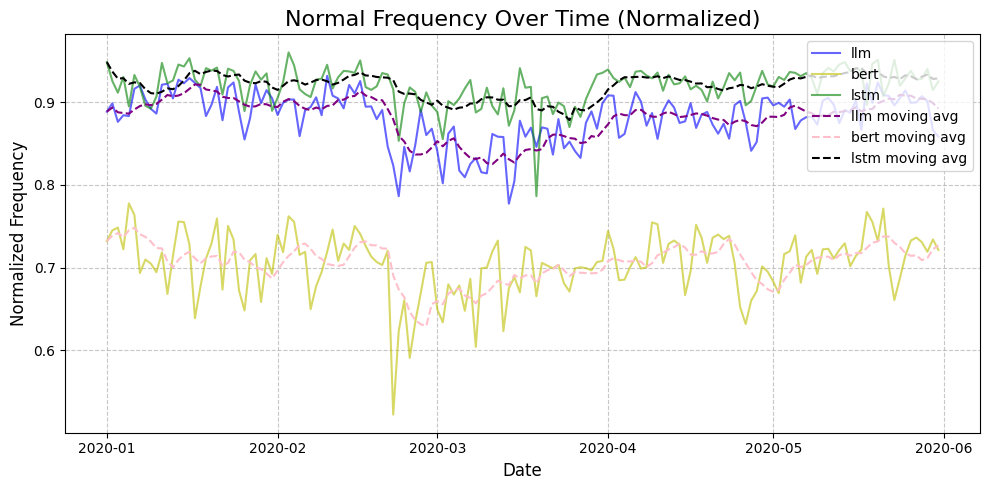

<ipython-input-10-220b918cbaca>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



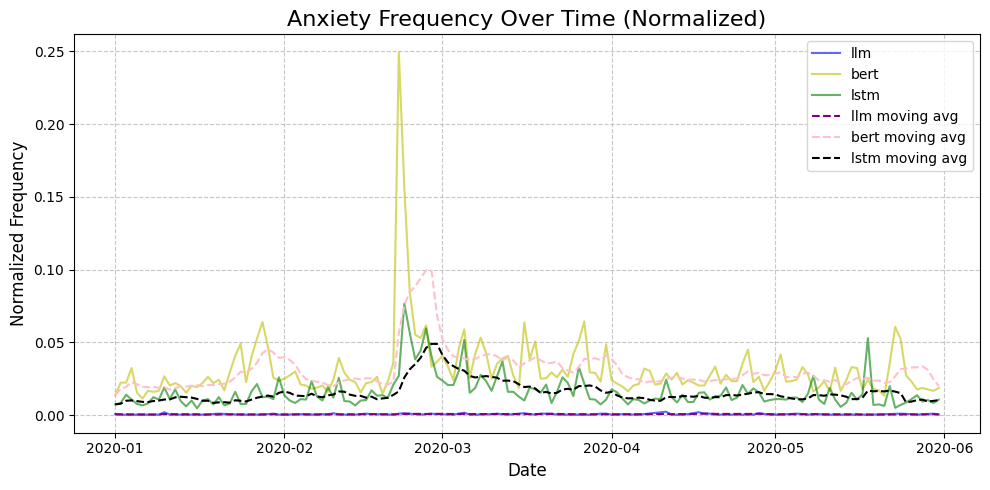

<ipython-input-10-220b918cbaca>:27: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



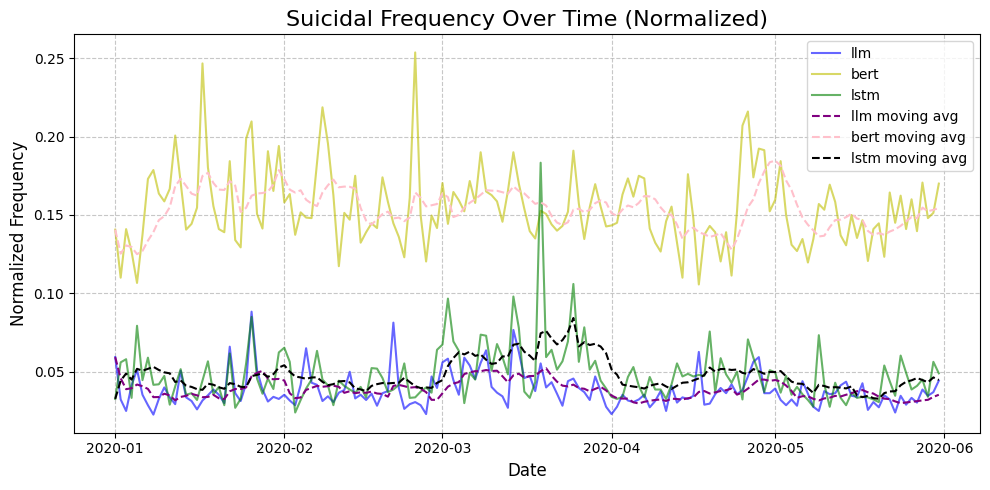

In [10]:
from typing_extensions import final
import matplotlib.pyplot as plt
import pandas as pd

df['tweet_date'] = pd.to_datetime(df['tweet_date'], format='%Y-%m-%d')

class_frequencies_llm = df.groupby(['tweet_date', 'llama_prediction']).size().reset_index(name='count')
class_frequencies_bert =  df.groupby(['tweet_date', 'bert_prediction']).size().reset_index(name='count')

class_frequencies_lstm = df.groupby(['tweet_date', 'lstm_prediction']).size().reset_index(name='count')
class_frequencies_llm['normalized_count'] = class_frequencies_llm['count'] / 3000
class_frequencies_bert['normalized_count'] = class_frequencies_bert['count'] / 3000
class_frequencies_lstm['normalized_count'] = class_frequencies_lstm['count'] / 3000
# Mapping of class IDs to class names
id2label = {0: 'Depression', 1: 'Normal', 2: 'Anxiety', 3: 'Suicidal'}

unique_classes = class_frequencies_llm['llama_prediction'].unique()

for prediction_class in unique_classes:
    llm = class_frequencies_llm[class_frequencies_llm['llama_prediction'] == prediction_class]
    bert = class_frequencies_bert[class_frequencies_bert['bert_prediction'] == prediction_class]
    lstm = class_frequencies_lstm[class_frequencies_lstm['lstm_prediction'] == prediction_class]
    llm = llm.sort_values('tweet_date')

    lstm = lstm.sort_values('tweet_date')
    llm['moving_avg'] = llm['normalized_count'].rolling(window=7, min_periods=1).mean()
    bert['moving_avg'] = bert['normalized_count'].rolling(window=7, min_periods=1).mean()
    lstm['moving_avg'] = lstm['normalized_count'].rolling(window=7, min_periods=1).mean()

    plt.figure(figsize=(10, 5))
    plt.plot(llm['tweet_date'], llm['normalized_count'], label="llm", color='b', alpha=0.6)
    plt.plot(bert['tweet_date'], bert['normalized_count'], label="bert", color='y', alpha=0.6)
    plt.plot(lstm['tweet_date'], lstm['normalized_count'], label="lstm", color='g', alpha=0.6)
    plt.plot(llm['tweet_date'], llm['moving_avg'], label="llm moving avg", color='purple', linestyle='--')
    plt.plot(bert['tweet_date'], bert['moving_avg'], label="bert moving avg", color='pink', linestyle='--')
    plt.plot(lstm['tweet_date'], lstm['moving_avg'], label="lstm moving avg", color='black', linestyle='--')
    plt.title(f"{id2label[prediction_class]} Frequency Over Time (Normalized)", fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Normalized Frequency", fontsize=12)
    plt.grid(visible=True, linestyle='--', alpha=0.7)

    plt.legend(loc='upper right', fontsize=10)

    plt.tight_layout()
    plt.show()


### Using Plotly

In [11]:
import plotly.express as px
import plotly.graph_objects as go
import pandas as pd

df['tweet_date'] = pd.to_datetime(df['tweet_date'], format='%Y-%m-%d')

class_frequencies_llm = df.groupby(['tweet_date', 'llama_prediction']).size().reset_index(name='count')
class_frequencies_bert = df.groupby(['tweet_date', 'bert_prediction']).size().reset_index(name='count')
class_frequencies_lstm = df.groupby(['tweet_date', 'lstm_prediction']).size().reset_index(name='count')

class_frequencies_llm['normalized_count'] = class_frequencies_llm['count'] / 3000
class_frequencies_bert['normalized_count'] = class_frequencies_bert['count'] / 3000
class_frequencies_lstm['normalized_count'] = class_frequencies_lstm['count'] / 3000

id2label = {0: 'Depression', 1: 'Normal', 2: 'Anxiety', 3: 'Suicidal'}

unique_classes = class_frequencies_llm['llama_prediction'].unique()

for prediction_class in unique_classes:
    class_name = id2label[prediction_class]

    llm = class_frequencies_llm[class_frequencies_llm['llama_prediction'] == prediction_class].sort_values('tweet_date')
    bert = class_frequencies_bert[class_frequencies_bert['bert_prediction'] == prediction_class].sort_values('tweet_date')
    lstm = class_frequencies_lstm[class_frequencies_lstm['lstm_prediction'] == prediction_class].sort_values('tweet_date')

    llm['moving_avg'] = llm['normalized_count'].rolling(window=7, min_periods=1).mean()
    bert['moving_avg'] = bert['normalized_count'].rolling(window=7, min_periods=1).mean()
    lstm['moving_avg'] = lstm['normalized_count'].rolling(window=7, min_periods=1).mean()

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=llm['tweet_date'], y=llm['normalized_count'], mode='lines', name='Llama', line=dict(color='blue', width=2)))
    fig.add_trace(go.Scatter(x=bert['tweet_date'], y=bert['normalized_count'], mode='lines', name='BERT', line=dict(color='red', width=2)))
    fig.add_trace(go.Scatter(x=lstm['tweet_date'], y=lstm['normalized_count'], mode='lines', name='AB-BiLSTM', line=dict(color='green', width=2)))

    fig.add_trace(go.Scatter(x=llm['tweet_date'], y=llm['moving_avg'], mode='lines', name='Llama Moving Avg', line=dict(color='purple', dash='dash')))
    fig.add_trace(go.Scatter(x=bert['tweet_date'], y=bert['moving_avg'], mode='lines', name='BERT Moving Avg', line=dict(color='pink', dash='dash')))
    fig.add_trace(go.Scatter(x=lstm['tweet_date'], y=lstm['moving_avg'], mode='lines', name='AB-BiLSTM Moving Avg', line=dict(color='black', dash='dash')))

    fig.update_layout(
        title=f"{class_name} Frequency Over Time (Normalized)",
        xaxis_title="Date",
        yaxis_title="Normalized Frequency",
        legend_title="Model",
        template="plotly_white"
    )

    fig.show()

## Analysis

#### Model confidence

In [17]:
df_log =  pd.read_csv('/content/drive/MyDrive/Italian thesis/Training dataset/italian_with_predictions_and_logits.csv')
import re
import ast
import numpy as np

df_log['lstm_logits'] = df_log['lstm_logits'].str.replace(r'(?<=\d)\s+(?=\d)', ', ', regex=True)

df_log['llama_logits'] = df_log['llama_logits'].apply(ast.literal_eval)
df_log['bert_logits'] = df_log['bert_logits'].apply(ast.literal_eval)
df_log['lstm_logits'] = df_log['lstm_logits'].apply(ast.literal_eval)

def extract_logit(logits_column, prediction_column):
    extracted_logits = []
    for logits, pred in zip(logits_column, prediction_column):
        if isinstance(logits, list) and isinstance(pred, (int, np.integer)) and 0 <= pred < len(logits):
            extracted_logits.append(logits[pred])
        else:
            extracted_logits.append(None)
    return extracted_logits

df_log['llama_predicted_logit'] = extract_logit(df_log['llama_logits'], df_log['llama_prediction'])
df_log['bert_predicted_logit'] = extract_logit(df_log['bert_logits'], df_log['bert_prediction'])
df_log['lstm_predicted_logit'] = extract_logit(df_log['lstm_logits'], df_log['lstm_prediction'])
import plotly.graph_objects as go
import pandas as pd
import numpy as np

df_log['tweet_date'] = pd.to_datetime(df_log['tweet_date'], format='%Y-%m-%d')

logits_llm = df_log.groupby(['tweet_date', 'llama_prediction'])['llama_predicted_logit'].mean().reset_index()
logits_bert = df_log.groupby(['tweet_date', 'bert_prediction'])['bert_predicted_logit'].mean().reset_index()
logits_lstm = df_log.groupby(['tweet_date', 'lstm_prediction'])['lstm_predicted_logit'].mean().reset_index()

logits_llm['probability'] = 1 / (1 + np.exp(-logits_llm['llama_predicted_logit']))
logits_bert['probability'] = 1 / (1 + np.exp(-logits_bert['bert_predicted_logit']))

logits_lstm['probability'] = logits_lstm['lstm_predicted_logit']

id2label = {0: 'Depression', 1: 'Normal', 2: 'Anxiety', 3: 'Suicidal'}

unique_classes = logits_llm['llama_prediction'].unique()

for prediction_class in unique_classes:
    class_name = id2label[prediction_class]

    logits_llm_class = logits_llm[logits_llm['llama_prediction'] == prediction_class].sort_values('tweet_date')
    logits_bert_class = logits_bert[logits_bert['bert_prediction'] == prediction_class].sort_values('tweet_date')
    logits_lstm_class = logits_lstm[logits_lstm['lstm_prediction'] == prediction_class].sort_values('tweet_date')

    logits_llm_class['moving_avg'] = logits_llm_class['probability'].rolling(window=7, min_periods=1).mean()
    logits_bert_class['moving_avg'] = logits_bert_class['probability'].rolling(window=7, min_periods=1).mean()
    logits_lstm_class['moving_avg'] = logits_lstm_class['probability'].rolling(window=7, min_periods=1).mean()

    fig = go.Figure()

    fig.add_trace(go.Scatter(x=logits_llm_class['tweet_date'], y=logits_llm_class['probability'], mode='lines',
                             name='Llama Confidence (Probability)', line=dict(color='blue', width=2)))

    fig.add_trace(go.Scatter(x=logits_bert_class['tweet_date'], y=logits_bert_class['probability'], mode='lines',
                             name='BERT Confidence (Probability)', line=dict(color='red', width=2)))

    fig.add_trace(go.Scatter(x=logits_lstm_class['tweet_date'], y=logits_lstm_class['probability'], mode='lines',
                             name='LSTM Confidence (Probability)', line=dict(color='green', width=2)))

    fig.add_trace(go.Scatter(x=logits_llm_class['tweet_date'], y=logits_llm_class['moving_avg'], mode='lines',
                             name='Llama Moving Avg', line=dict(color='blue', dash='dot', width=2)))

    fig.add_trace(go.Scatter(x=logits_bert_class['tweet_date'], y=logits_bert_class['moving_avg'], mode='lines',
                             name='BERT Moving Avg', line=dict(color='red', dash='dot', width=2)))

    fig.add_trace(go.Scatter(x=logits_lstm_class['tweet_date'], y=logits_lstm_class['moving_avg'], mode='lines',
                             name='LSTM Moving Avg', line=dict(color='green', dash='dot', width=2)))

    fig.update_layout(
        title=f"Model Confidence Over Time for '{class_name}' Class",
        xaxis_title="Date",
        yaxis_title="Confidence (Probability)",
        legend_title="Model",
        template="plotly_white"
    )

    fig.show()


#### Depression


When it comes to the ’Depression’ class, there is some discrepancy between the models, with the biggest outlier being the AB-BiLSTM model. This however does not come as a surprise as it is the class where all models performed the worst. Further analysis can be done by utilizing the prediction confidence graph. The figure shows the average confidence level per day for a given model. It is obtained by applying the softmax function to the logits output by the model, with the class chosen for an example being the one with the highest probability. Although analyzing the prediction confidence should not be the only metric, it explains the discrepancy between the AB-BiLSTM model and the other two models for this class. The AB-BiLSTM’s confidence fluctuates a lot, while Llama and BERT have much more stable values. The model also has very low confidence values, with said values dropping as low as 0.42. The range of values is also very low compared to the others as seen from the figure. This, along with the bad performance on the mental health dataset suggests that the model might be suffering from underfitting. The explanation for this is that the model might have not recognized the underlying patterns well enough during training causing it to not be confident when making predictions.

Going back to the predictions made by the models, there are some interesting takeaways. The first one is the massive spike in both the BERT and the Llama on the 23rd of February to the 26th of February. This is the period where the COVID-19 numbers started to drastically increase and the government started to implement stricter measures to combat the spread of the disease including imposing fines on people leaving the outbreak zones. A word cloud for ’depressive’ tweets during that period is shown below. As seen in the figure there are a lot of words that relate to the pandemic. Words and pairs like ’amuchina’ which translates to ’hand sanitizer’, ’pasta’,and ’mercator nero’ which translates to ’black market’ are very prominent. These words all relate to the panic buying that ensued [7] after the lockdown measures started to ramp up in Italy. There are also terms related to the pandemic itself such as ’coronavirus venire’ which translates to ’coronavirus is coming’ and ’positivi coronavirus’ which translates to ’coronavirus positives’ alluding to the positive cases. The phrases ’guerre fame’ translating to ’hunger wars’ and ’fame vera’ translating to ’real hunger’ also alludes to people’s hopelessness and attitude towards the food shortage caused by the panic buying. There is also an alarming amount of tweets mentioning running
away or fleeing. This is evident by the word ’fuga’ which translates to ’flee’.

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


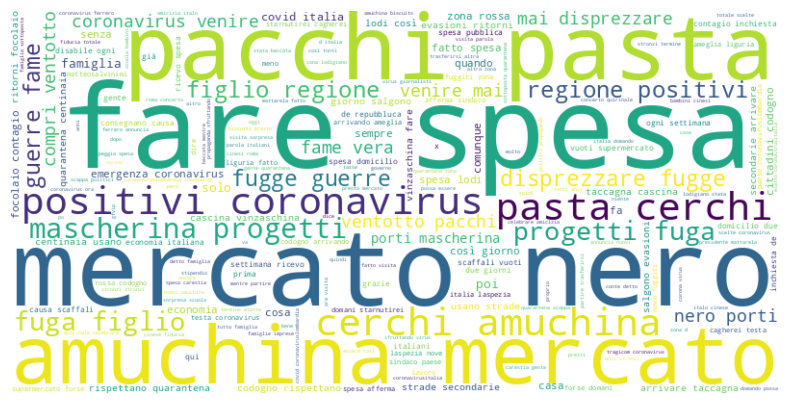

In [25]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords

nltk.download('stopwords')
stop_words = set(stopwords.words('italian'))
stop_words.add('rt')


df['tweet_date'] = pd.to_datetime(df['tweet_date'], format='%Y-%m-%d')

filtered_df = df[
    (df['tweet_date'] >= "2020-02-23") &
    (df['tweet_date'] <= "2020-02-26") &
    ((df['bert_prediction'] == 1) |
     (df['llama_prediction'] == 1) |
     (df['lstm_prediction'] == 1))
]

text = " ".join(filtered_df['testo'].dropna())

text = re.sub(r'\W+', ' ', text.lower())

words = text.split()
words = [word for word in words if word not in stop_words]

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(" ".join(words))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()


#### Anxiety

When it comes to tweets exhibiting anxiety symptoms, a very interesting phenomenon occurred, which is that the Llama model barely classified any tweets as ’Anxious’. The reason could be that the model might only classify tweets in this class if they show obvious signs of anxiety. Another possible cause would be that the model picks up on sarcasm, while the other two would not due to the massive amount of pre-training the Llama went through while the other did not. The downside of using LLMs is evident here as due to their black-box nature, getting an answer might be impossible. Analyzing the other two models’ results however still follow the hypothesis previously discussed as there is a spike around the same period as the depression timeseries.


Upon further analysis, and as seen in the confidence graph showing the average model confidence for the ’Anxiety’ classifications per day, it paints a clearer picture as to why the Llama model prediction frequency is much lower for the ’Anxiety’ than the BERT and the AB-BiLSTM models. The figure shows that the Llama model is very inconsistent when it comes to its level of confidence. With some predictions having a confidence of almost 1 (January 6th), and others having a confidence as low as 0.5 (January 11th). On the other hand, the BERT for example has a much more consistent graph. Although the confidence never reaches values as high as the ones produced by the Llama, the model performs at a good level (around 0.9) and does not fluctuate as much. This intense fluctuation shows that the Llama model is not really certain when making predictions, at first glance it might be thought of as a problem of consistency when it comes to the data. However, the consistent performance of other models go against this. A plausible reason could be that the Llama model is overfitting and has failed to generalize. Although the model performed exceptionally well for this class on the mental health classification dataset, it might have still overfit to that dataset and not generalized well for this class. With the high confidence levels with the strong fluctuations being a sign that the model is too sensitive to specific data patterns. These fluctuations make it more reasonable to use the results of the more stable models as a more realistic measure of the level of anxiety of the general public, rather than the more volatile Llama. It is also evident that the AB-BiLSTM overall has lower values , showing that the BERT model might be the model that generalized the best out of the three for this class. However, this can not be taken as a definitive explanation as the Llama model has a very low amount of ’Anxiety’ classifications per day.




Furthermore, the most common trigrams for ’Anxiety’ classifications by BERT and AB-BiLSTM while excluding Llama classifications is displayed below. In the same figure, the most common trigrams for Llama classifications are also displayed. As seen from the Llama graph, the model seems to be mostly picking up tweets regarding the European Stability Mechanism (MES) and the Coronabond issued by the EU during that time period. It seems that the Llama model is only concerned with financial anxiety, unlike the other two models where we see anxiety related to going shopping (’fare la spesa’) for example. We also see some anxiety in relation to the death count as seen by the trigram ’e mortale in’ which translates to ’and deadly in’. BERT and AB-BiLSTM also classify a lot of tweets referring to isolation caused by COVID as shown by the repetition of the word ’isolato’ in multiple trigrams, which translates to ’isolation’. In conclusion, although Llama does have a higher F1-score for the ’Anxiety’ class than the other two models, it seems that it did not generalize well as the tweets do no exhibit signs of sarcasm as first expected.

In [ ]:
import pandas as pd
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
import plotly.express as px
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('punkt_tab')

stop_words = set(stopwords.words('italian'))

def get_trigrams(text):
    tokens = word_tokenize(text.lower())
    return list(ngrams(tokens, 3))

filtered_df = df[
    ((df['bert_prediction'] == 2) |
     (df['lstm_prediction'] == 2)) &
    ((df['llama_prediction'] != 2) )
]


trigrams = filtered_df['testo'].apply(get_trigrams)

all_trigrams = [item for sublist in trigrams for item in sublist]

trigram_counts = Counter(all_trigrams)

most_common_trigrams = trigram_counts.most_common(10)

trigrams_labels = [' '.join(trigram) for trigram, _ in most_common_trigrams]
frequencies = [count for _, count in most_common_trigrams]

fig = px.bar(
    x=frequencies,
    y=trigrams_labels,
    orientation='h',
    labels={'x': 'Frequency', 'y': 'Trigrams'},
    title="Most Common Trigrams in Tweets classified as 'Anxious' by BERT and AB-BiLSTM, excluding Llama classifications",
    color=trigrams_labels,
    color_discrete_sequence=px.colors.qualitative.Set3
)
fig.update_layout(showlegend=False)

fig.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [24]:
import pandas as pd
from nltk.util import ngrams
from nltk.tokenize import word_tokenize
from collections import Counter
import nltk
import plotly.express as px
from nltk.corpus import stopwords

nltk.download('punkt')
nltk.download('stopwords')
stop_words = set(stopwords.words('italian'))

def get_trigrams(text):
    tokens = word_tokenize(text.lower())
    return list(ngrams(tokens, 3))

filtered_df = df[

    ((df['llama_prediction'] == 2) )
]


trigrams = filtered_df['testo'].apply(get_trigrams)

all_trigrams = [item for sublist in trigrams for item in sublist]

trigram_counts = Counter(all_trigrams)

most_common_trigrams = trigram_counts.most_common(10)

trigrams_labels = [' '.join(trigram) for trigram, _ in most_common_trigrams]
frequencies = [count for _, count in most_common_trigrams]

fig = px.bar(
    x=frequencies,
    y=trigrams_labels,
    orientation='h',
    labels={'x': 'Frequency', 'y': 'Trigrams'},
    title="Most Common Trigrams in Tweets classified as 'Anxious' by BERT and AB-BiLSTM, excluding Llama classifications",
    color=trigrams_labels,
    color_discrete_sequence=px.colors.qualitative.Set3
)
fig.update_layout(showlegend=False)

fig.show()


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


#### Suicidal

Looking at the timeseries graph it is once again evident that there is some bias in the llama model in comparison to the other two. Although not as low as the ’Anxiety’ class predictions, the number of ’Suicidal’ predictions is still much lower than the other models. This class is also the most inconsistent of all classes as the values are not similar at all between the three models. There is a slight increase in the moving averages, specifically for the AB-BiLSTM model. However, this model performs very weakly in this class.


This class is also the most sensitive one given the implications, so the confidence here is actually very important. As shown in the confidence graph, it is evident that the AB-BiLSTM model has very low confidence in its predictions. The confidence values also have a very high variance, so once again this might be a sign of underfitting for this model. The BERT model has very stable confidence, but as discussed earlier, predictive confidence on its own is not enough to determine a model’s performance as overconfidence can be another sign of overfitting. Hence, this class’s results are not enough to make inference about the population’s mental health when it comes to having suicidal symptoms as a result of ongoing events.

#### Normal
The last class examined by the models is the ’Normal’ class. This class is arguably the most important as it can act as a reflection of the general public’s mental health. This is caused by the fact that classification that belong to other classes ’take away’ from this class’s frequency. As a result, a dip in the trend means an overall decline in mental health and vice versa. Looking at the timeseries graph and taking the analysis of the other classes’ results reflects this.


Looking at the moving averages for the three models, there is an obvious dip around the 20th of February. As mentioned before, this time period corresponds to a drastic increase in the COVID-19 positive cases as well as the government implementing much stricter measures. As expected, this had a negative impact on the mental health of Italian people which manifested in different ways depending on the person. This is also reflected by the sharp decline in the frequency values for all 3 models on the 23rd of February. Although the models have somewhat different frequency values for the classes, they all still agree on the overall trend. The Llama model has a much higher frequency for this class, which can be explained by the extremely low classifications of both the ’Anxiety’ and ’suicidal’ class classifications. Although the graph is somewhat varied, the trends (especially the ones repre- sented by the moving averages) are very useful. Before the previously mentioned dip, the models hovered around a specific range with no obvious deviations. Then the dip took place followed by a recovery. This happened around the 2nd of April, where the models started to predict ’Normal’ tweets with the same frequency it previously did. A significant development around this period was the fact that the ’panic buying’ behavior started to subside, this occurred after the general public started to adapt to the current situation and started to refrain from excessive stockpiling. It is also plausible that people started to get used to staying at home. Working from home, online learning, and the adoption of delivery services started to spread even more. The public was now able to live their life with some sense of normality, producing a possible explanation for the recovery from the dip in overall mental health.

## Discussion
The results show that utilizing smaller LLMs like BERT and the more modern/larger ones like Llama can be a very useful tool when creating an indicator when utilizing big data resources. It is also noteworthy that smaller deep learning models like the AB-BiLSTM are not really suited to the task as even though it performed at a satisfactory level when being trained, it failed to generalize in any of the classes as seen by the confidence levels.
The usefulness of the models also heavily depends on the class, for example, the ’Suicidal’ class is very inconsistent along the three models. There are also some issues when it comes to the ’Anxiety’, specifically for the Llama model as it has very different results to the other two models. As discussed previously, it might be due to the model overfitting by relying on certain terms instead of learning the underlying patterns for the class. However, the results also show that the models can be very useful when looking at the ’Depression’ class as all three models have a somewhat similar trend that coincides with the events related to the pandemic. The word clouds as well as the trigram graphs also support this due to the terms mostly
being related to people’s worries during that time. Last, but not least, the ’Normal’ graph provided the best representation of the events. It shows the dip in the overall mental health followed by a recovery over the latter end of the period analyzed.
The results also show that the BERT model might have generalized better than the Llama better as evident by the ’Anxiety’ class results, as well as showing the same trends in both the ’Depression’ and ’Normal’ classes as the Llama model. It also still performed at a good level during the training phase. Hence, from the results, LLMs can be a useful tool when developing indicators, while traditional deep learning models like the AB-BiLSTM model can be too simple for this task, leading to underfitting issues.